In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import time


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
# n_subjects = 3;
# subjects = np.arange(8, 11)
subjects = np.arange(1, 11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')

save_filename1 = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
print(save_filename1)
print(time.ctime(os.path.getmtime(save_filename1)))
dec_withintask1 = np.load(save_filename1, allow_pickle=True).item()

save_filename2 = os.path.join(save_folder, 'decode_multiclass_withintask_newsubs.npy')
print(save_filename2)
print(time.ctime(os.path.getmtime(save_filename2)))
dec_withintask2 = np.load(save_filename2, allow_pickle=True).item()
dec_withintask2.keys()

dec_withintask = dict([])
for kk in list(dec_withintask1.keys()):
    print(kk)
    if kk not in ['preds_all','probs_all']:
        # print(dec_withintask1[kk].shape)
        dec_withintask[kk] = np.concatenate([dec_withintask1[kk], dec_withintask2[kk]], axis=0)
        print(dec_withintask[kk].shape)
    else:
        dec_withintask[kk] = dec_withintask1[kk]
        # print(dec_withintask1[kk].keys())
        for si in dec_withintask2[kk].keys():
            # print(si, si+7)
            dec_withintask[kk][si+7] = dec_withintask2[kk][si]
        print(dec_withintask[kk].keys())
        
dec_withintask['roi_names'] = dec_withintask1['roi_names']
dec_withintask['grid_pts'] = dec_withintask1['grid_pts']

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask.npy
Fri Jun  2 12:40:24 2023
/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask_newsubs.npy
Tue Aug 13 08:41:26 2024
acc_bytask
(10, 8, 4)
dprime_bytask
(10, 8, 4)
preds_all
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
probs_all
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
acc_each_cval
(10, 8, 4, 12, 20)
best_cval
(10, 8, 4, 12)
grid_pts
(32, 2)
roi_names
(16,)


In [6]:
roi_names = dec_withintask['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)
roi_names

['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPS']

#### compute Checker Task accuracy for different sets of trials
far, medium are all in main grid, different positions relative to boundaries


In [7]:
n_tasks = 3

conf_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

ii = 0;

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        dist = l['dist_from_bound3'].round(2)
        
        categ_actual = np.array(l['categ_task3']).astype(int)
        
        un_dist = np.unique(dist[is_main_grid])
        
        is_middle = is_main_grid & (dist==0.8)
        is_far = is_main_grid & (dist==2.4)
        
        correct = np.array(l['subject_correct'])
        
        for ri in range(n_rois):

            pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

            coords_pred = grid_pts[pred,:]
            categ_pred = grid_utils.get_categ(coords_pred, 3)
            
            prob = dec_withintask['probs_all'][si][ri][ti]

            # "confidence" in assignment to category 2 vs 1
            # group the 16 points into categories w/r/t relevant axis
            g1 = grid_utils.get_categ(grid_pts, 3)==1
            p_categ1 = np.sum(prob[:,g1], axis=1)
            g2 = grid_utils.get_categ(grid_pts, 3)==2
            p_categ2 = np.sum(prob[:,g2], axis=1)

            # signed confidence will be: p(correct) - p(incorrect)
            signedconf = np.zeros_like(p_categ1)
            signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
            signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

            # far trials
            inds = is_far & correct

            conf_fartrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_fartrials[si,ri,ti,ii] = d;

            acc_fartrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # middle trials
            inds = is_middle & correct

            conf_midtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_midtrials[si,ri,ti,ii] = d;

            acc_midtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])


In [8]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

-0.04646217600541901 0.690038966129523
-0.08290870292822126 0.785562649803857
-0.07662004954781498 0.7134238638429601
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/multinomial_nonlinear_confidence.pdf
-0.02756616335026381 0.35567940150234756
-0.04649450198976697 0.45605311025067324
-0.04296986081105712 0.4143377649234035
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/multinomial_nonlinear_confidence.pdf


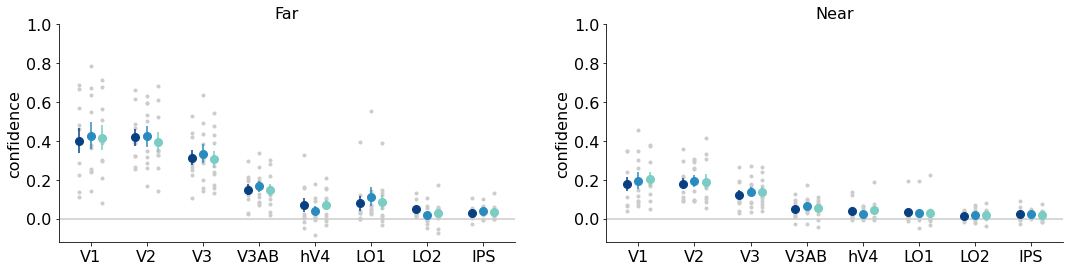

In [9]:
ti_plot = [0,1,2]

plt.figure(figsize=(18,4))

x_jitter = np.linspace(-0.2, 0.2, 3)

pi=0

for rvals, name in zip([conf_fartrials, conf_midtrials], \
                     ['Far','Near']):

    pi+=1
    ax = plt.subplot(1,2,pi)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = rvals[:,:,ti,ii]
        print(np.min(vals), np.max(vals))
        
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
        
        plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8,0.8], zorder=-10)

    ylims = [-0.12, 1.0]
    # ylims = [-0.2, 0.6]
    assert(np.all(rvals[:,:,ti_plot,:]>ylims[0]))
    assert(np.all(rvals[:,:,ti_plot,:]<ylims[1]))
    plt.ylim(ylims)

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    # plt.legend(lh,np.array(task_names)[ti_plot])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(name)

    # plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)

    figname = os.path.join(figfolder, 'multinomial_nonlinear_confidence.pdf')
    print(figname)
    plt.savefig(figname)

In [12]:
for rvals, diffname in zip([conf_fartrials, conf_midtrials], \
                     ['Far','Near']):

    vals = rvals[:,:,:,0]

    anova_result = stats_utils.rmanova_2way(vals, ['ROI','Task'], 
                                                do_shuffle=True, n_iter=10000, rndseed = 868679)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    tablename = os.path.join(figfolder, 'checker_rm_anova_%s.csv'%(diffname))
    
    print(tablename)
    anova_result.to_csv(tablename)


/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/checker_rm_anova_Far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/checker_rm_anova_Near.csv


In [10]:
for diffname in ['Far', 'Near']:
    
    tablename = os.path.join(figfolder, 'checker_rm_anova_%s.csv'%(diffname))
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    anova_result = pd.read_csv(tablename, index_col=0)
    print('\nAnova for Checker confidence, %s trials'%(diffname))
    
    print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/checker_rm_anova_Far.csv
Sat Dec 14 09:08:06 2024

Anova for Checker confidence, Far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       41.697617     7.0    63.0  0.0000           0.0000
Task       0.497021     2.0    18.0  0.6164           0.6179
ROI:Task   0.669316    14.0   126.0  0.8004           0.8059
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/checker_rm_anova_Near.csv
Sat Dec 14 09:19:43 2024

Anova for Checker confidence, Near trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       23.863028     7.0    63.0  0.0000           0.0000
Task       0.509179     2.0    18.0  0.6094           0.6200
ROI:Task   0.577307    14.0   126.0  0.8786           0.8854
